# Balanced Data Augmentation & Class Weighting 실습

이번 실습에서는 **Class Imbalance 문제**를 다루는 두 가지 방법을 비교합니다.

- Baseline (불균형 데이터 그대로 학습)
- Balanced Data Augmentation (소수 클래스만 증강)
- Class Weighting (소수 클래스에 가중치 부여)

CIFAR-10 (Cat vs Dog) 데이터셋으로 실험합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## 1. 데이터 준비 (CIFAR-10: Cat vs Dog, 불균형 만들기)

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train, y_test = y_train.flatten(), y_test.flatten()

# 클래스 3=Cat, 5=Dog
mask_train = (y_train == 3) | (y_train == 5)  # 3=Cat, 5=Dog
mask_test = (y_test == 3) | (y_test == 5)
X_train, y_train = X_train[mask_train], y_train[mask_train]
X_test, y_test = X_test[mask_test], y_test[mask_test]

# 라벨 재정의: Cat=0, Dog=1
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Cat 샘플 줄여서 불균형 만들기
# cat data를 20%만 사용
cat_idx = np.where(y_train == 0)[0]
dog_idx = np.where(y_train == 1)[0]
np.random.seed(42)
cat_idx_reduced = np.random.choice(cat_idx, size=len(cat_idx)//5, replace=False)
imbalanced_idx = np.concatenate([cat_idx_reduced, dog_idx])
X_train, y_train = X_train[imbalanced_idx], y_train[imbalanced_idx]

X_train = X_train.astype("float32")/255.0
X_test = X_test.astype("float32")/255.0

print("Train class distribution (imbalanced):", np.bincount(y_train))

Train class distribution (imbalanced): [1000 5000]


## 2. CNN 모델 정의

In [3]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(32,32,3)),
        tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 3. Balanced Data Augmentation (소수 클래스만 증강)

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

cat_imgs = X_train[y_train==0]
dog_imgs = X_train[y_train==1]
cat_labels = y_train[y_train==0]
dog_labels = y_train[y_train==1]

needed = len(dog_labels) - len(cat_labels)
print(needed)
augmented_cats, augmented_labels = [], []

# 소수 클래스(Cat)만 증강
for X_batch, y_batch in datagen.flow(cat_imgs, cat_labels, batch_size=32, seed=42):
    augmented_cats.append(X_batch)
    augmented_labels.append(y_batch)
    if len(np.concatenate(augmented_labels)) >= needed:
        break

augmented_cats = np.concatenate(augmented_cats)[:needed]
augmented_labels = np.concatenate(augmented_labels)[:needed]

# X_balanced = np.concatenate([X_train, augmented_cats, dog_imgs])
# y_balanced = np.concatenate([y_train, augmented_labels, dog_labels])
X_balanced = np.concatenate([X_train, augmented_cats])
y_balanced = np.concatenate([y_train, augmented_labels])

print("Balanced train class distribution:", np.bincount(y_balanced))

4000
Balanced train class distribution: [5000 5000]


## 4. Class Weighting 설정

In [5]:
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(3.0), 1: np.float64(0.6)}


## 5. 학습 (Baseline vs Balanced Augmentation vs Class Weighting)

In [6]:
histories = {}

# Baseline
model_base = build_model()
histories["Baseline"] = model_base.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=5, batch_size=64, verbose=0
)

# Balanced Data Augmentation
model_aug = build_model()
histories["Balanced Augmentation"] = model_aug.fit(
    X_balanced, y_balanced, validation_data=(X_test, y_test),
    epochs=5, batch_size=64, verbose=0
)

# Class Weighting
model_weighted = build_model()
histories["Class Weighting"] = model_weighted.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=5, batch_size=64, class_weight=class_weights, verbose=0
)

## 6. 결과 비교 시각화

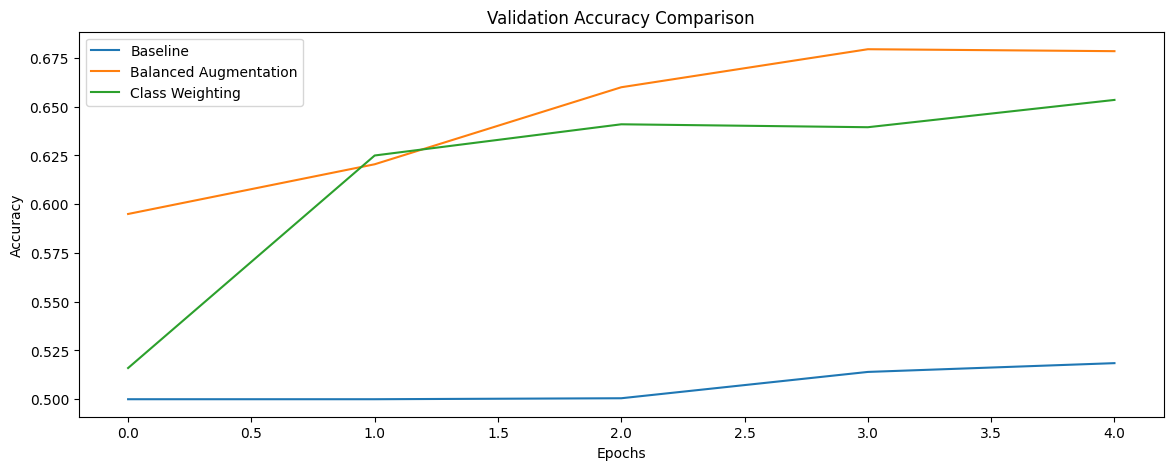

In [7]:
plt.figure(figsize=(14,5))
for name, history in histories.items():
    plt.plot(history.history["val_accuracy"], label=name)
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report (Baseline):
              precision    recall  f1-score   support

           0     0.8776    0.0430    0.0820      1000
           1     0.5095    0.9940    0.6737      1000

    accuracy                         0.5185      2000
   macro avg     0.6935    0.5185    0.3778      2000
weighted avg     0.6935    0.5185    0.3778      2000



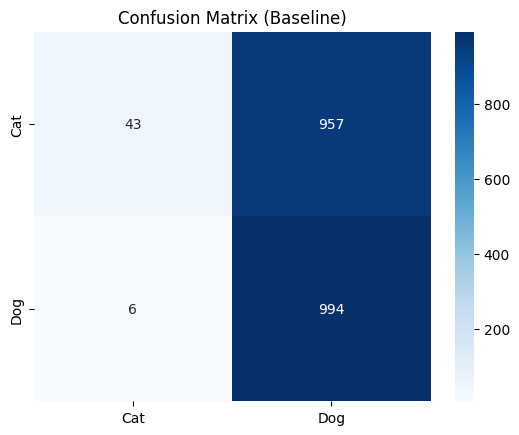

In [8]:
y_pred = (model_base.predict(X_test) > 0.5).astype(int)
print("Classification Report (Baseline):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.title("Confusion Matrix (Baseline)")
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report (Augmentation):
              precision    recall  f1-score   support

           0     0.7107    0.6020    0.6519      1000
           1     0.6548    0.7550    0.7013      1000

    accuracy                         0.6785      2000
   macro avg     0.6828    0.6785    0.6766      2000
weighted avg     0.6828    0.6785    0.6766      2000



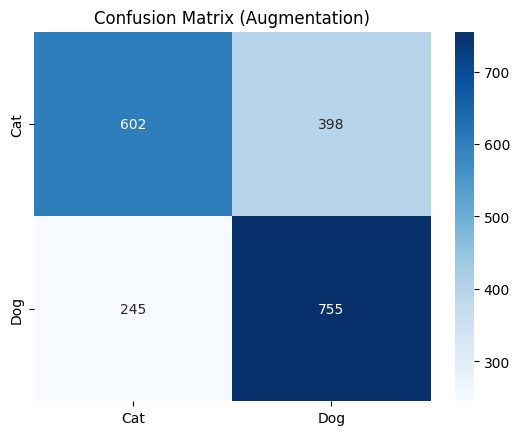

In [9]:
y_pred = (model_aug.predict(X_test) > 0.5).astype(int)
print("Classification Report (Augmentation):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.title("Confusion Matrix (Augmentation)")
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report (Class weighting):
              precision    recall  f1-score   support

           0     0.7571    0.4520    0.5661      1000
           1     0.6094    0.8550    0.7116      1000

    accuracy                         0.6535      2000
   macro avg     0.6833    0.6535    0.6388      2000
weighted avg     0.6833    0.6535    0.6388      2000



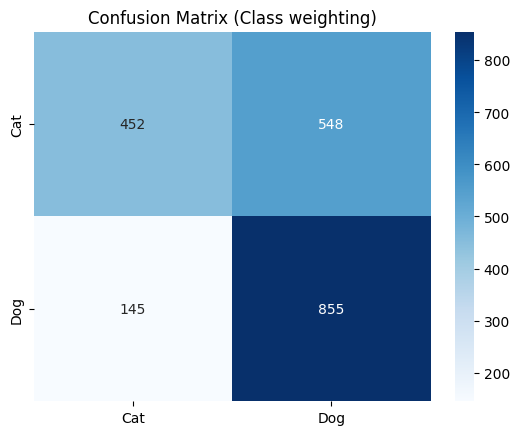

In [10]:
y_pred = (model_weighted.predict(X_test) > 0.5).astype(int)
print("Classification Report (Class weighting):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Cat","Dog"], yticklabels=["Cat","Dog"])
plt.title("Confusion Matrix (Class weighting)")
plt.show()